Trains an approximation for the sigmoid function, for x belonging in a specific range of values, in the general form

$σ(x) = a * (\frac{bx}{c + d|x|} + e), x \in [\text{lowerBound}, \text{upperBound}]$

Where $a, b, c, d, e$ are trainable parameters. We only train approximators for positive values of x. For negative values, we can easily compute the result through the symmetry of the sigmoid function: $σ(-x) = 1 - σ(x)$

This general form of the sigmoid function was inspired by [this StackOverflow reply](https://stackoverflow.com/questions/10732027/fast-sigmoid-algorithm/10733861#comment112899113_10733861), where the following branchless, exponential-less approximation is suggested:

$f(x) = 0.5 * (\frac{x}{1 + |x|} + 1)$

Note: `a` is technically redundant here. It can be removed completely, requiring the other parameters to be retrained, without sacrificing accuracy. It's only present in this code to match the general form of the approximation from the StackOverflow reply

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

%matplotlib inline

In [2]:
def sigmoid_numpy(x):
    return 1.0 / (1.0 + np.exp(-x))

# Exponential-less, branchless sigmoid approximation (https://stackoverflow.com/questions/10732027/fast-sigmoid-algorithm/10733861#comment112899113_10733861)
def fast_sigmoid_branchless(x):
    return 0.5 * (x / (1 + np.abs(x)) + 1)

# Neural network to find approximation formulae for the sigmoid function in a given number range
# Based on our branchless approximation, we look for solutions with the general form
# σ(x) = a * (b * x / (c + d * np.abs(x)) + e), where x belongs in [lower bound, upper bound]
# By piecing together multiple of these solutions for different boundaries, with some fixups (to guarantee monotony/continuity, etc) we can derive a 
# very good, hardware-friendly sigmoid approximation
class SigmoidApproximator(nn.Module):
    def __init__(self, lowerBound, upperBound):
        assert lowerBound < upperBound
        super(SigmoidApproximator, self).__init__()

        self.lowerBound = lowerBound
        self.upperBound = upperBound
        
        self.a = nn.Parameter(torch.randn(1))
        self.b = nn.Parameter(torch.randn(1))
        self.c = nn.Parameter(torch.randn(1))
        self.d = nn.Parameter(torch.randn(1))
        self.e = nn.Parameter(torch.randn(1))

        self.lossFn = nn.MSELoss()
        
    def forward(self, x):
        return self.a * (self.b * x / (self.c + self.d * torch.abs(x)) + self.e)
    
    def loss(self, y_pred, y_true):
        # Apply penalty for any values outside [0, 1], the proper output range of the sigmoid function
        penalty = 0.0
        penaltyFactor = 10
        
        # Penalties if prediction is < 0 or > 1
        penalty += torch.sum(torch.relu(-y_pred)) * penaltyFactor
        penalty += torch.sum(torch.relu(y_pred - 1.0)) * penaltyFactor
        
        # Total loss = MSE loss + penalty
        return self.lossFn(y_pred, y_true) + penalty
    
    def paramsToFloat(self):
        # Convert parameters from tensors to floats and return them
        params = [self.a, self.b, self.c, self.d, self.e]
        return [param.data.float() for param in params]

def getSigmoidApproximation(*, lowerBound, upperBound, N, epochs):
    nn = SigmoidApproximator(lowerBound, upperBound)
    nn.train()

    optimizer = torch.optim.Adam(nn.parameters(), lr = 0.001)

    # Generate N samples from lowerBound to upperBound
    x = np.linspace(lowerBound, upperBound, N)
    y_true = torch.Tensor(sigmoid_numpy(x))

    x = torch.Tensor(x)
    
    for epoch in range(0, epochs):
        optimizer.zero_grad()
        y_pred = nn(x)

        loss = nn.loss(y_pred, y_true)
        loss.backward()
        optimizer.step()

    return nn.paramsToFloat()

def plotApproximation(lowerBound, upperBound, a, b, c, d, e):    
    # Plot full sigmoid function
    x = np.linspace(-8, 8, 10000)
    y = sigmoid_numpy(x)
    plt.plot(x, y, color = "blue", label = "Numpy sigmoid")

    # Plot approximation for boundary
    x = np.linspace(lowerBound, upperBound, 10000)
    y = a * (b * x / (c + d * np.abs(x)) + e)
    plt.plot(x, y, color = "orange", label = "Approximation for given boundary")

    plt.legend()
    plt.show()
    
def printParameters(lowerBound, upperBound, a, b, c, d, e):
    print(f"Estimated parameters for bound [{lowerBound}, {upperBound}]")
    print(f"    a: {a}")
    print(f"    b: {b}")
    print(f"    c: {c}")
    print(f"    d: {d}")
    print(f"    e: {e}")

In [3]:
def getAndGraphApproximator(*, lowerBound, upperBound, N = 1000, epochs = 100000):
    (a, b, c, d, e) = getSigmoidApproximation(lowerBound = lowerBound, upperBound = upperBound, N = N, epochs = epochs)
    printParameters(lowerBound, upperBound, a, b, c, d, e)
    plotApproximation(lowerBound, upperBound, a, b, c, d, e)
    
    return (a, b, c, d, e)

Approximator for $x \in [0.0, 1.0]$

Estimated parameters for bound [0, 1]
    a: tensor([-0.4050])
    b: tensor([-0.2953])
    c: tensor([0.4560])
    d: tensor([0.0574])
    e: tensor([-1.2323])


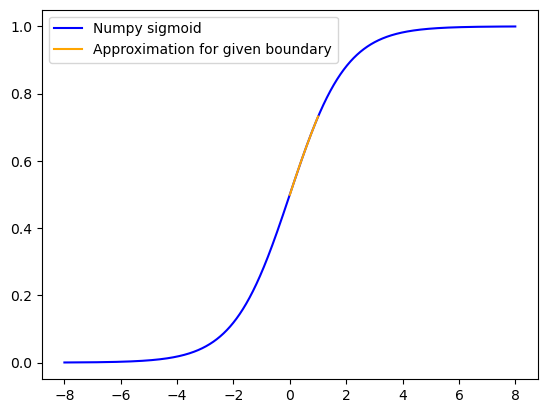

(tensor([-0.4050]),
 tensor([-0.2953]),
 tensor([0.4560]),
 tensor([0.0574]),
 tensor([-1.2323]))

In [ ]:
lower, upper = 0, 1
getAndGraphApproximator(lowerBound = lower, upperBound = upper)

Approximator for $x \in [1.0, 2.0]$

Estimated parameters for bound [1, 2]
    a: tensor([0.8590])
    b: tensor([-0.7971])
    c: tensor([-1.3510])
    d: tensor([-0.7695])
    e: tensor([0.4744])


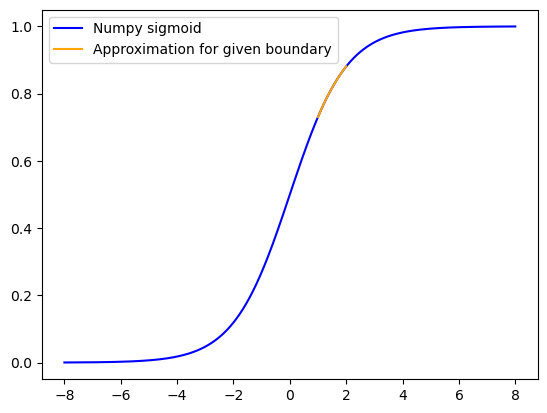

(tensor([0.8590]),
 tensor([-0.7971]),
 tensor([-1.3510]),
 tensor([-0.7695]),
 tensor([0.4744]))

In [ ]:
lower, upper = 1, 2
getAndGraphApproximator(lowerBound = lower, upperBound = upper)

Approximator for $x \in [2.0, 4.0]$

Estimated parameters for bound [2, 4]
    a: tensor([0.9184])
    b: tensor([-0.8653])
    c: tensor([-0.1881])
    d: tensor([-0.5366])
    e: tensor([-0.4091])


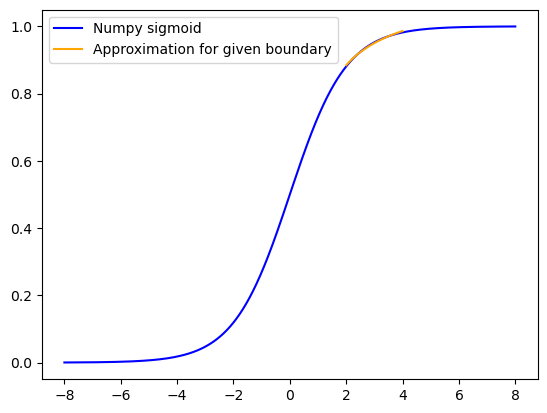

(tensor([0.9184]),
 tensor([-0.8653]),
 tensor([-0.1881]),
 tensor([-0.5366]),
 tensor([-0.4091]))

In [ ]:
lower, upper = 2, 4
getAndGraphApproximator(lowerBound = lower, upperBound = upper)

Approximator for $x \in [4.0, 6]$

Estimated parameters for bound [4, 6]
    a: tensor([-2.1050])
    b: tensor([-0.0309])
    c: tensor([2.3130])
    d: tensor([-1.3891])
    e: tensor([-0.5050])


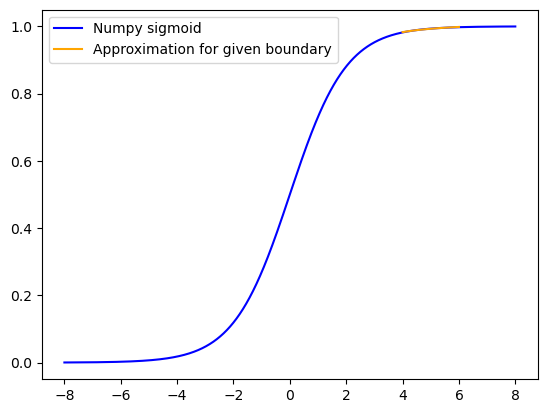

(tensor([-2.1050]),
 tensor([-0.0309]),
 tensor([2.3130]),
 tensor([-1.3891]),
 tensor([-0.5050]))

In [ ]:
lower, upper = 4, 6
getAndGraphApproximator(lowerBound = lower, upperBound = upper)

σ(x) for x >= ~6 is practically 0.99999...

In [8]:
print(sigmoid_numpy(6.9))

0.9989932291799144


In [9]:
print(sigmoid_numpy(7.3))

0.9993249172693672
